In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression

### Define Dimensions

* we choose an underdetermined where N << d

In [3]:
N = 5
d = 25

### Define Dataset

* to make sure the data is realizable by a linear model we create the y using a fitter linear regressor.

* the regressor is chosen to have positive coefficients and no intercept to simulate our u^2 model.

In [4]:
x = np.random.normal(size=(N, d))
y_inital = np.zeros((N,))    # this is just a place-hold for the shape of y

In [5]:
reg = LinearRegression().fit(x, y_inital)
reg.coef_ = np.random.random(size=(d,))   # set positive coefficients only

In [6]:
y = reg.predict(x)

### Define Gradient Decent

* $r_n(t) = \mathbf{X}^T \cdot \mathbf{u}^2(t) - y$

* $\dot{\mathbf{u}_i}(t) = - \mathbf{u}_i(t) \sum_n x_{n, i} r_n(t)$

* $L(u) = \frac12 \sum_n r_n(t)^2$

In [7]:
def update(u, x, y, step_size):
    r = np.dot(x, u**2) - y
    grad_u = - np.multiply(np.dot(x.transpose(), r), u)
    u = u + step_size * grad_u
    loss = 0.5 * np.sum(r**2)
    return u, loss

### Define Q

* $q(z) = \frac{z \cdot (ln(z) - 1)}{2}$
* $Q(w) = \sum_{i \in [d]} w_i(0) \cdot q(\frac{w_i}{w_i(0)})$

In [8]:
def q_func(x):
    return 0.5 * x * (np.log(x) - 1)

In [9]:
def Q_func(w, w_0):
    f = 0
    for w_i, w_0_i in zip(w, w_0):
        f += w_0_i * q_func(w_i / w_0_i)
    return f

In [10]:
def solver(x, y, w_0, obj='L1', optim_tol=1e-6):
    
    cons = {'type': 'eq', 'fun': lambda w: np.dot(x, w) - y}

    if obj == 'L1':
        objective = lambda w: np.linalg.norm(w, ord=1)
    elif obj == 'L2':
        objective = lambda w: np.linalg.norm(w, ord=2)
    elif obj == 'Q':
        objective = lambda w: Q_func(w, w_0)
    else:
        raise ValueError('objective not supported.')
    
    sol = minimize(
        fun=objective,
        x0=w_0,
        constraints=cons,
        tol=optim_tol,
        method='SLSQP',
        options={
            'maxiter': 100000,
            'disp': True
        }
    )
    is_failed = (not sol.success)
    if is_failed:
        raise RuntimeError('Minimization Failed.')

    return sol.x

### Find L1 / L2 solutions

In [11]:
u_0 = np.random.normal(size=(d,))
w_0 = u_0**2

In [12]:
w_opt_L1 = solver(x, y, w_0, obj='L1', optim_tol=1e-5)

minimal_L1 = np.linalg.norm(w_opt_L1, ord=1)
minimal_L1

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.055365811605283
            Iterations: 72
            Function evaluations: 2077
            Gradient evaluations: 72


2.055365811605283

In [13]:
loss = 0.5 * np.sum((np.dot(x, w_opt_L1) - y)**2)
loss

2.0514748839360977e-21

In [14]:
w_opt_L2 = solver(x, y, w_0, obj='L2', optim_tol=1e-5)

minimal_L2 = np.linalg.norm(w_opt_L2, ord=2)
minimal_L2

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7357987989594365
            Iterations: 5
            Function evaluations: 137
            Gradient evaluations: 5


0.7357987989594365

In [15]:
loss = 0.5 * np.sum((np.dot(x, w_opt_L2) - y)**2)
loss

3.404863667515818e-14

### Run GD

* check GD solutions at high / low $\alpha$ values where:
* $u_0 \sim{}  N(0, \alpha)$ 

In [16]:
def run_GD(alpha, n_epochs, step_size):
    u_0 = np.random.normal(size=(d,), loc=0, scale=alpha)   
    u = np.array(u_0)

    for epoch in range(n_epochs):
        u, loss = update(u, x, y, step_size)
        
    L1 = np.linalg.norm(u**2, ord=1)
    L2 = np.linalg.norm(u**2, ord=2)
    return L1, L2, u, loss

In [17]:
L1, L2, u, loss = run_GD(alpha=0.01, n_epochs=10000, step_size=0.001)
L1, L2, loss

(2.2251826376349686, 0.966552777524224, 2.711569813345748e-07)

In [18]:
L1, L2, u, loss = run_GD(alpha=2, n_epochs=10000, step_size=0.001)
L1, L2, loss

(61.748761319613486, 18.82267991945502, 1.694448957697434e-27)

### Solve Q

In [19]:
L1_Q = []
L2_Q = []
loss_Q = []

for alpha in [1e-2, 1e-1, 0.5, 1, 2]:
    u_0 = np.random.normal(size=(d,), loc=0, scale=alpha)   
    w_0 = np.array(u_0**2)

    w_opt_Q = solver(x, y, w_0, obj='Q', optim_tol=1e-5)
    
    loss_Q.append(0.5 * np.sum((np.dot(x, w_opt_Q) - y)**2))
    L1_Q.append(np.linalg.norm(w_opt_Q, ord=1))
    L2_Q.append(np.linalg.norm(w_opt_Q, ord=2))

/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 10.128045956327979
            Iterations: 381
            Function evaluations: 11405
            Gradient evaluations: 381
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.8099021300149007
            Iterations: 172
            Function evaluations: 4920
            Gradient evaluations: 172
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3.11619907993015
            Iterations: 30
            Function evaluations: 845
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -10.726604455330392
            Iterations: 28
            Function evaluations: 785
            Gradient evaluations: 28
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -48.60185289667856
            Iterations: 38
        

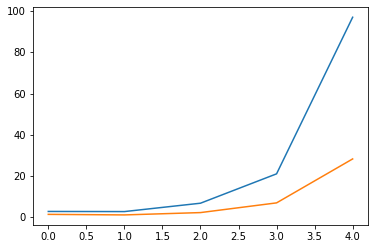

In [20]:
plot(L1_Q);
plot(L2_Q);

In [21]:
loss_Q

[7.494535192822811e-18,
 4.464127022013282e-24,
 4.992665732486714e-20,
 1.9292240544902215e-20,
 7.892632559308931e-19]